In [1]:
from torchvision.datasets import CelebA
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose

transform = Compose([
    Resize((218, 218)),
    ToTensor()

])

train = CelebA("data", "train", download=True, transform=transform)
valid = CelebA("data", "valid", download=True, transform=transform)
test = CelebA("data", "test", download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Number of pictures: 162770
Number of attributes: 40
Attribute names: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Resolution: torch.Size([3, 218, 218])


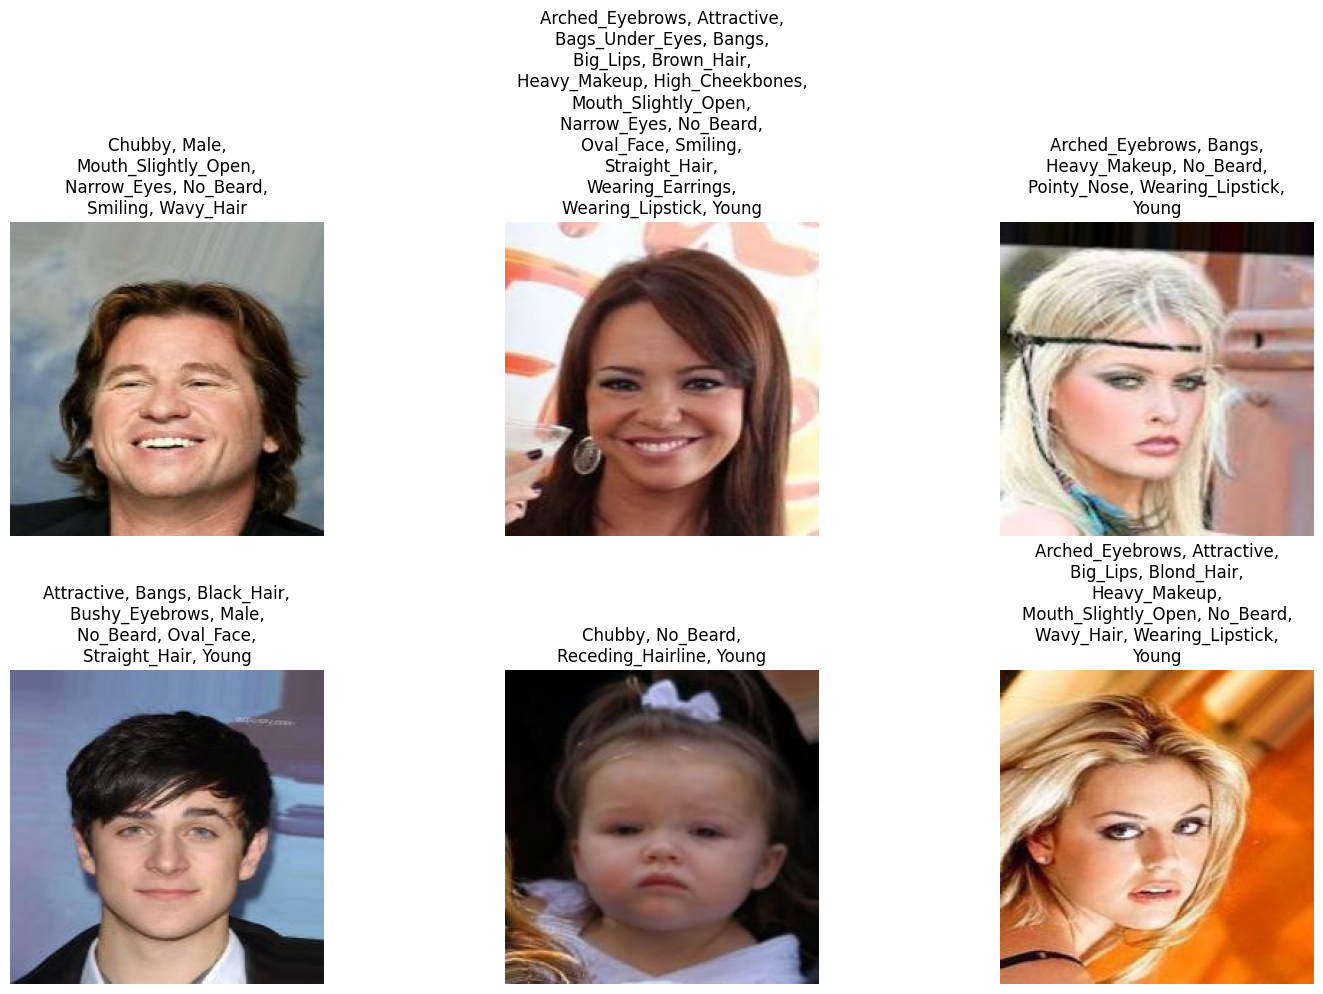

In [2]:
import matplotlib.pyplot as plt
import random
import textwrap

print(f"Number of pictures: {len(train)}")

print(f"Number of attributes: {len(train.attr_names[:-1])}")

print(f"Attribute names: {train.attr_names[:-1]}")

print(f"Resolution: {train[0][0].shape}")

# Define the number of rows and columns for the grid of images
ROWS = 2
COLS = 3

# Create subplots
fig, axs = plt.subplots(ROWS, COLS, figsize=(5*COLS, 5*ROWS))

# Randomly select images
selected_images = random.sample(range(len(train)), ROWS * COLS)

for i in range(ROWS * COLS):
    # Get attributes for the current image
    attrs = [attr for j, attr in enumerate(train.attr_names[:-1]) if train[selected_images[i]][1][j] == 1]
    
    # Calculate the row and column indices for the current image
    row = i // COLS
    col = i % COLS
    
    # Display the image
    axs[row, col].imshow(train[selected_images[i]][0].permute(1, 2, 0))

    # Remove the axes
    axs[row, col].axis('off')
    
    # Set the title to the attributes, with line breaks
    title = ", ".join(attrs)
    axs[row, col].set_title(textwrap.fill(title, 30))

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
from efficientformer_v3 import EfficientFormerV3
from torchvision.transforms import ToTensor
from torch import cuda, backends

device = (
    "cuda"
    if cuda.is_available()
    else "mps"
    if backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

BATCH_SIZE = 32

model = EfficientFormerV3(batch_size=BATCH_SIZE).to(device)

print(model)

example = train[0][0].unsqueeze(0).to(device)
model.forward(example)


/Users/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cyanosite/Development/Facial-Attribute-Recognition/model/efficientformer_v2.py:632: UserWarning: Overwriting efficientformerv2_s0 in registry with efficientformer_v2.efficientformerv2_s0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/cyanosite/Development/Facial-Attribute-Recognition/model/efficientformer_v2.py:646: UserWarning: Overwriting efficientformerv2_s1 in registry with efficientformer_v2.efficientformerv2_s1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/cyanosite/Development/Facial-Attribute-Reco

Using mps device
EfficientFormerV3(
  (network): Sequential(
    (0): EfficientFormerV2(
      (patch_embed): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate='none')
      )
      (network): ModuleList(
        (0): Sequential(
          (0): FFN(
            (mlp): Mlp(
              (fc1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
              (act): GELU(approximate='none')
              (fc2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
              (drop): Dropout(p=0.0, inplace=False)
              (mid): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
          

tensor([[0.5074, 0.4895, 0.5046, 0.5000, 0.5009, 0.4978, 0.4892, 0.5035, 0.5073,
         0.5060, 0.4993, 0.4996, 0.4903, 0.5058, 0.4949, 0.4985, 0.5019, 0.5082,
         0.4989, 0.5095, 0.5088, 0.4991, 0.4945, 0.4983, 0.5077, 0.4910, 0.5149,
         0.5080, 0.4895, 0.4988, 0.4933, 0.4890, 0.4932, 0.4974, 0.4911, 0.5081,
         0.4900, 0.5092, 0.5106, 0.4961]], device='mps:0',
       grad_fn=<CatBackward0>)

In [4]:
from torch import nn, optim

loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

from efficientformer_v3 import train_loop, test_loop
train_loop(train_loader, model, loss_fn, optimizer, device)
test_loop(valid_loader, model, loss_fn, device)

loss: 0.691949  [   32/162770]
loss: 0.679737  [ 3232/162770]
loss: 0.665453  [ 6432/162770]


KeyboardInterrupt: 

In [ ]:
import torch
import torchvision

@torch.no_grad()
def trace(model, example):
    model.eval()
    return torch.jit.trace(model, example)
traced_model = trace(model, example)
out = traced_model(example)

import coremltools as ct


# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example.shape)]
 )

# Save the converted model.
model.save("newmodel.mlpackage")

Torch version 2.2.1 has not been tested with coremltools. You may run into unexpected errors. Torch 2.1.0 is the most recent version that has been tested.
Running MIL default pipeline:   0%|          | 0/71 [00:00<?, ? passes/s]/Users/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/Users/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:267: UserWarning: Output, '1597', of the source model, has been renamed to 'var_1597' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 642.33 passes/s]
